# [GCViT: Global Context Vision Transformer](https://arxiv.org/pdf/2206.09959v1.pdf)
<img src="https://raw.githubusercontent.com/awsaf49/gcvit-tf/main/image/lvg_arch.PNG" width=1200>

# Agenda
* This notebook explores the recently published (`20 Jun 2022`) **Global Context Vision Transformer (GCViT)** architecture, with **TensorFlow**.
* This notebook is not completely beginner friendly, we need to have previous knowledge of **Matrix-Operation**, **Transformer**, **Self-Attention**, **WindowAttention**, and a bit of **CNN**, check Reference section for links to the tutorials.
* It also gives a peek at **GCViT** in action with **live-demo**.
* It attempts to answer **Why** each component is used and **How** do they work under the hood.
* It also evaluates the model in **ImageNetV2** dataset with ported weights from **Official** repo.
* It also demonstrates how can we **Reuse** its code for other tasks on different datasets with minimal change of code.
* It also shows how to train **GCViT** for custom dataset like **Flower Classification**.

# Live Demo
Before we dive into the paper, if you want to see **GCViT** live in action like a "Desert before Dinner" person like me, I have created this WebApp with Gradio in HuggingFace Space,
 <a target="_blank" href="https://huggingface.co/spaces/awsaf49/gcvit-tf"><img src="https://img.shields.io/badge/🤗%20Hugging%20Face-Spaces-yellow.svg"></a> 
This app uses **GCViT** for image classification tasks. Here is an example how it looks like,
> **Note:** This app uses **TensorFlow** implementation of **GCViT** with ported weights from official repo.

<a href="https://huggingface.co/spaces/awsaf49/gcvit-tf"><img src="https://raw.githubusercontent.com/awsaf49/gcvit-tf/main/image/gradio_demo.JPG" width=1200></a>

# Import Libraries

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("../usr/lib/gcvit_utils")  # building blocks which will be discussed below
from gcvit_utils import *

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(0)

# Table of Contents
1. [Introduction](#1.-Introduction)
1. [Methodology](#2.-Methodology)
1. [Architecture](#3.-Architecture)
    1. [Unit Blocks](#Unit-Blocks)
    1. [Model](#Model)
    1. [Stem](#Stem)
    1. [Level](#Level)
    1. [Block](#Block)
    1. [Stem](#Stem)
    1. [Global Token Gen.](#Global-Token-Gen.)
    1. [Attention](#Attention)
1. [Build Model](#4.-Build-Model)
1. [Reproducibility](#5.-Reproducibility)
1. [Reusability](#6.-Reusability)
1. [Flower Classification](#7.-Flower-Classification)
1. [Conclusion](#9.-Conclusion)
1. [Reference](#10.-Reference)


# 1. Introduction
> **Note:** In this section we'll learn about the backstory of GCViT and try to understand why it is proposed.

* During recent years, **Transformers** have achieved dominance in **Natural Language Processing (NLP)** tasks and with the **self-attention** mechanism which allows for capturing both long and short-range information. 
* Following this trend, **Vision Transformer (ViT)** proposed to utilize image patches as tokens in a gigantic architecture similar to encoder of the original Transformer. 
* Despite the historic dominance of **Convolutional Neural Network (CNN)** in computer vision, **ViT-based** models have shown **SOTA or competitive performance** in various computer vision tasks.

<div align="center"> <img src="https://raw.githubusercontent.com/awsaf49/gcvit-tf/main/image/vit_gif.gif" width=600></div>

* However, **quadratic [$O(n^2)$] computational complexity** of self-attention and **lack of multi-scale information** makes it difficult for **ViT** to be considered as general-purpose architecture for Compute Vision tasks like **segmentation and object detection** where it requires **dense prediction at the pixel level**.
* Swin Transformer has attempted to address the issues of **ViT** by proposing **multi-resolution/hierarchical** architectures in which the self-attention is computed in **local windows** and cross-window connections such as **window shifting** are used for modeling the interactions across different regions. But the **limited receptive field of local windows** can not capture long-range information, and cross-window-connection schemes such as **window-shifting only cover a small neighborhood** in the vicinity of each window. Also, it lacks **inductive-bias** that encourages certain translation invariance is still preferable for general-purpose visual modeling, particularly for the dense prediction tasks of object detection and semantic segmentation.

<div align="center">
<img src="https://raw.githubusercontent.com/awsaf49/gcvit-tf/main/image/swin_vs_vit.JPG" width=400>     <img src="https://raw.githubusercontent.com/awsaf49/gcvit-tf/main/image/shifted_window.JPG" width=400>
<img src="https://raw.githubusercontent.com/awsaf49/gcvit-tf/main/image/swin_arch.JPG" width=800></div>

* To address above limitations, **Global Context (GC) ViT** network is proposed.

> **Summary:** `Transformer` is proposed to capture long-range information with `self-attention` mechanism, but it comes with `quadratic computation` cost and lacks `multi-resolution` information. Later on `Swin Transformer` introduces `local-window-self-attention` to reduce the cost to linear w.r.t image size, `shifted-window-attention` to capture cross-window information and finally exploits `multi-resolution` information with hierarchical architecture. But `shifted-window-attention` struggles to capture long-range information due to small coverage area of `shifted-window-attention` and lacks `inductive-bias` like ViT. Finally, `Global Context ViT` is proposed to address limitations of Swin Transformer.

# 2. Methodology
* This paper proposes a novel architecture namely, **Global Context Vision Transformer (GCViT)** that utilizes window attention mechanism similar to **Swin Transformer**.
* Unlike **Swin Transformer** this paper uses **global context self-attention**, with local self-attention, rather than **shifted window self-attention**, to model both long and short-range dependencies.
* Even though **global-window-attention** is a window-attention but it takes leverage of **global query** which contains global information hence captures long-range information.
* In addition, this paper compensates for the lack of the **inductive bias** that exists in both ViTs and Swin Transformer by utilizing a **CNN** based module.
* GCViT achieves state-of-the-art results across image classification, object detection and semantic segmentation tasks.

> **Summary:** Global Context ViT (**GCViT**) is a hierarchical architecture like **Swin Transformer** but utilizes`global-window-attention` instead of `shifted-window-attention` for effectively capturing long-range information. It also introduces **CNN** based module to include **inductive-bias** a useful feature for image that has been missing in both **ViT** and **Swin Transformer**.

# 3. Architecture
> **Notes**: In this following sections we'll dive deep into the model architecture and try to understand why each component has been used and what are they doing under the hood. At first glance, code may seem very intimidating but believe me it's not. I think one of the best parts of building model in `tf.keras.Model` is that is very easy to understand what is going on inside. Hence, I encourage you to first have a look at the `call` method of each component before exploring its complete code. We'll use the Top to Down approach to understand the architecture.

Let's have a quick **overview** of our key components,
1. `Stem/PatchEmbed:` A stem/patchify layer processes images at the network’s beginning. For this network, it creates **patches/tokens** and converts them into **embeddings**.
1. `Level:` It is the repetitive building block that extracts features using different blocks.
    1. `Global Token Gen./FeatExtract:` It generates **global tokens/patches** with **Depthwise-CNN**, **SE (Squeeze-Excitation)**, **CNN** and **MaxPooling**. So basically it's a Feature Extractor.
    1. `Block:` It is the repetitive module that applies attention to the features and projects them to a certain dimension.
        1. `Local-MSA:` Local Multi head Self Attention.
        1. `Global-MSA:` Global Multi head Self Attention.
        1. `MLP:` Linear layer that projects a vector to another dimension.
    1. `Downsample/ReduceSize:` It is very similar to **Global Token Gen.** module except it uses **CNN** instead of **MaxPooling** to downsample with additional **Layer Normalization** modules.
1. `Head:` It is the module responsible for the classification task.
    1. `Pooling:` It converts $N \times 2D$ features to $N \times 1D$ features.
    1. `Classifier:` It processes $N \times 1D$ features to make a decision about class.

I've annotated the architecture figure to make it easier to digest,
<img src="https://raw.githubusercontent.com/awsaf49/gcvit-tf/main/image/arch_annot.png">

## Unit Blocks
> **Note:** This blocks are used to build other modules throughout the paper. Most of the blocks are either borrowed from other work or modified version old work.

1. `SE`: **Squeeze-Excitation (SE)** aka **Bottleneck** module acts sd kind of **channel attention**. It consits of **AvgPooling**, **Dense/FullyConnected (FC)/Linear** , **GELU** and **Sigmoid** module.

<div align="center">
<img src="https://raw.githubusercontent.com/awsaf49/gcvit-tf/main/image/se_annot.png" width=400>
</div>

1. `Fused-MBConv:` This is similar to the one used in **EfficientNetV2**. It uses **Depthwise-Conv**, **GELU**, **SE**, **Conv**, to extract feature with a resiudal connection. Note that, no new module is declared for this one, we simply applied corresponding modules directly.

<div align="center">
<img src="https://raw.githubusercontent.com/awsaf49/gcvit-tf/main/image/fmb_annot.png" width=350>
</div>

1. `ReduceSize`: It is a **CNN** based **downsample** module which abvobe mentioned `Fused-MBConv` module to extract feature, **Strided Conv** to simultaneously reduce spatial dimension and increse channelwise dimention of the features and finally **LayerNormalization** module to normalize features. In the paper/figure this module is referred as **downsample** module. I think it is mention worthy that **SwniTransformer** used `PatchMerging` module instead of `ReduceSize` to reduce the spatial dimention and increase channelwise dimension which uses **fully-connected/dense/linear** module. According to the **GCViT** paper, one of the purposes of using `ReduceSize` is to add inductive bias through **CNN** module.

<div align="center">
<img src="https://raw.githubusercontent.com/awsaf49/gcvit-tf/main/image/down_annot.png" width=300>
</div>

1. `MLP:` This is our very own **Multi Layer Perceptron** module. This a feed-forward/fully-connected/linear module which simply projects input to an arbitary dimension.

1. `DropPath/StocasticDepth:` This operation is explaied in the figure below from the paper. It reduces the depth of a network during trainings, while keeping it unchanged during testing. This is achieved by randomly deactivating entire ResBlocks during training and bypassing their transformations through skip connections. 

<div align="center">
<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-06_at_12.42.59_PM.png" width=600>
</div>

1. `Identity`: This module is tensorflow ver. of pytorch `nn.Identity` module which simply passes through the input without any modification.

In [2]:
class SE(tf.keras.layers.Layer):
    """
    Squeeze and excitation block
    """

    def __init__(self, oup=None, expansion=0.25, **kwargs):
        """
        Args:
            oup: output features dimension, if `None` use same dim as input.
            expansion: expansion ratio.
        """
        super().__init__(**kwargs)
        self.expansion = expansion
        self.oup = oup

    def build(self, input_shape):
        inp = input_shape[-1]
        self.oup = self.oup or inp
        self.avg_pool = tfa.layers.AdaptiveAveragePooling2D(1, name="avg_pool")
        self.fc = [
            tf.keras.layers.Dense(
                int(inp * self.expansion), use_bias=False, name="fc/0"
            ),
            tf.keras.layers.Activation("gelu", name="fc/1"),
            tf.keras.layers.Dense(self.oup, use_bias=False, name="fc/2"),
            tf.keras.layers.Activation("sigmoid", name="fc/3"),
        ]
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        b, _, _, c = tf.unstack(tf.shape(inputs), num=4)
        x = tf.reshape(self.avg_pool(inputs), (b, c))
        for layer in self.fc:
            x = layer(x)
        x = tf.reshape(x, (b, 1, 1, c))
        return x * inputs


class ReduceSize(tf.keras.layers.Layer):
    """
    Down-sampling block based on: "Hatamizadeh et al.,
    Global Context Vision Transformers <https://arxiv.org/abs/2206.09959>"
    """

    def __init__(self, keep_dim=False, **kwargs):
        """
        Args:
            keep_dim: if False spatial dim is reduced and channel dim is increased
        """
        super().__init__(**kwargs)
        self.keep_dim = keep_dim

    def build(self, input_shape):
        embed_dim = input_shape[-1]
        dim_out = embed_dim if self.keep_dim else 2 * embed_dim
        self.pad1 = tf.keras.layers.ZeroPadding2D(1, name="pad1")
        self.pad2 = tf.keras.layers.ZeroPadding2D(1, name="pad2")
        self.conv = [
            tf.keras.layers.DepthwiseConv2D(
                kernel_size=3, strides=1, padding="valid", use_bias=False, name="conv/0"
            ),
            tf.keras.layers.Activation("gelu", name="conv/1"),
            SE(name="conv/2"),
            tf.keras.layers.Conv2D(
                embed_dim,
                kernel_size=1,
                strides=1,
                padding="valid",
                use_bias=False,
                name="conv/3",
            ),
        ]
        self.reduction = tf.keras.layers.Conv2D(
            dim_out,
            kernel_size=3,
            strides=2,
            padding="valid",
            use_bias=False,
            name="reduction",
        )
        self.norm1 = tf.keras.layers.LayerNormalization(
            axis=-1, epsilon=1e-05, name="norm1"
        )  # eps like PyTorch
        self.norm2 = tf.keras.layers.LayerNormalization(
            axis=-1, epsilon=1e-05, name="norm2"
        )
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = self.norm1(inputs)
        xr = self.pad1(x)
        for layer in self.conv:
            xr = layer(xr)
        x = x + xr
        x = self.pad2(x)
        x = self.reduction(x)
        x = self.norm2(x)
        return x


class Mlp(tf.keras.layers.Layer):
    """
    Multi-Layer Perceptron (MLP) block
    """

    def __init__(
        self,
        hidden_features=None,
        out_features=None,
        act_layer="gelu",
        dropout=0.0,
        **kwargs
    ):
        """
        Args:
            hidden_features: hidden features dimension.
            out_features: output features dimension.
            act_layer: activation function.
            dropout: dropout rate.
        """
        super().__init__(**kwargs)
        self.hidden_features = hidden_features
        self.out_features = out_features
        self.act_layer = act_layer
        self.dropout = dropout

    def build(self, input_shape):
        self.in_features = input_shape[-1]
        self.hidden_features = self.hidden_features or self.in_features
        self.out_features = self.out_features or self.in_features
        self.fc1 = tf.keras.layers.Dense(self.hidden_features, name="fc1")
        self.act = tf.keras.layers.Activation(self.act_layer, name="act")
        self.fc2 = tf.keras.layers.Dense(self.out_features, name="fc2")
        self.drop1 = tf.keras.layers.Dropout(self.dropout, name="drop1")
        self.drop2 = tf.keras.layers.Dropout(self.dropout, name="drop2")
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x


class DropPath(tf.keras.layers.Layer):
    """DropPath aka Stochastic Depth.
    ref: rwightman/pytorch-image-models
    """

    def __init__(self, drop_prob=0.0, scale_by_keep=True, **kwargs):
        """
        Args:
            drop_prob: probability to drop the residual
            scale_by_keep: scale the output
        """
        super().__init__(**kwargs)
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def call(self, x, training=None):
        if self.drop_prob == 0.0 or not training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
        random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
        random_tensor = tf.floor(random_tensor)
        if keep_prob > 0.0 and self.scale_by_keep:
            x = x / keep_prob
        return x * random_tensor


class Identity(tf.keras.layers.Layer):
    """
    Pass-through input without any change.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        return tf.identity(x)

In [3]:
inp = tf.random.uniform(shape=(1, 224, 224, 3))
print("\n## ReduceSize with keep_dim:")
layer = ReduceSize(keep_dim=True)
out = layer(inp)
print('input: ',inp.shape, '\noutput: ',out.shape)

print("\n## ReduceSize with no keep_dim:")
layer = ReduceSize(keep_dim=False)
inp = tf.random.uniform(shape=(1, 224, 224, 3))
out = layer(inp)
print('input: ',inp.shape, '\noutput: ',out.shape)

2022-08-19 05:57:45.075594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 05:57:45.194299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 05:57:45.195096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 05:57:45.202122: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil


## ReduceSize with keep_dim:


2022-08-19 05:57:49.664485: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


input:  (1, 224, 224, 3) 
output:  (1, 112, 112, 3)

## ReduceSize with no keep_dim:
input:  (1, 224, 224, 3) 
output:  (1, 112, 112, 6)


## Model
Let's directly jump to the model. As we can see from the `call` method,
1. It creates patch embeddings from an image. This layer doesn't flattens these embeddings which means output of this module will be $(batch, \frac{height}{window\_size}, \frac{width}{window\_size}, embed\_dim)$ instead of $(batch, \frac{height \times width}{window\_size^2}, embed\_dim)$.
1. Then it applies `Dropout` module which randomly sets input units to 0.
2. It passes these embeddings to series of `Level` modules which we are calling `level`  where,
    1. Global token is generated
    1. Both local & global attention is applied
    1. Finally downsample is applied. 
1. So, output after $n$ number of **levels**, shape: $(batch, \frac{width}{window\_size \times 2^{n-1}}, \frac{width}{window\_size \times 2^{n-1}}, embed\_dim \times 2^{n-1})$. In the last layer paper doesn't use **downsample** and increase **channels**.
3. Output of above layer is normalized using `LayerNormalization` module.
4. In the head, 2D features are converted to 1D features with `Pooling` module. Output shape after this module is $(batch, embed\_dim \times 2^{n-1})$
5. Finally, pooled features are sent to `Dense/Linear` module for classification.

> **Sumamry:** image $\rightarrow$ (patchs + embedding) $\rightarrow$ dropout $\rightarrow$ (attention + feature extraction) $\rightarrow$ normalizaion $\rightarrow$ pooling $\rightarrow$ classify

In [4]:
class GCViT(tf.keras.Model):
    """
    GCViT based on: "Hatamizadeh et al.,
    Global Context Vision Transformers <https://arxiv.org/abs/2206.09959>"
    """

    def __init__(
        self,
        window_size,
        embed_dim,
        depths,
        num_heads,
        drop_rate=0.0,
        mlp_ratio=3.0,
        qkv_bias=True,
        qk_scale=None,
        attn_drop=0.0,
        path_drop=0.1,
        layer_scale=None,
        num_classes=1000,
        head_act="softmax",
        **kwargs,
    ):
        """
        Args:
            embed_dim: feature size dimension.
            depths: number of layers in each stage.
            window_size: window size in each stage.
            mlp_ratio: MLP ratio.
            num_heads: number of heads in each stage.
            path_drop: drop path rate.
            num_classes: number of classes.
            qkv_bias: bool argument for query, key, value learnable bias.
            qk_scale: bool argument to scaling query, key.
            drop_rate: dropout rate.
            attn_drop: attention dropout rate.
            layer_scale: layer scaling coefficient.
        """
        super().__init__(**kwargs)
        self.window_size = window_size
        self.embed_dim = embed_dim
        self.depths = depths
        self.num_heads = num_heads
        self.drop_rate = drop_rate
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.attn_drop = attn_drop
        self.path_drop = path_drop
        self.layer_scale = layer_scale
        self.num_classes = num_classes
        self.head_act = head_act

        self.patch_embed = PatchEmbed(embed_dim=embed_dim, name="patch_embed")
        self.pos_drop = tf.keras.layers.Dropout(drop_rate, name="pos_drop")
        path_drops = np.linspace(0.0, path_drop, sum(depths))
        keep_dims = [
            (False, False, False),
            (False, False),
            (True,),
            (True,),
        ]
        self.levels = []
        for i in range(len(depths)):
            path_drop = path_drops[sum(depths[:i]) : sum(depths[: i + 1])].tolist()
            level = Level(
                depth=depths[i],
                num_heads=num_heads[i],
                window_size=window_size[i],
                keep_dims=keep_dims[i],
                downsample=(i < len(depths) - 1),
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop,
                path_drop=path_drop,
                layer_scale=layer_scale,
                name=f"levels/{i}",
            )
            self.levels.append(level)
        self.norm = tf.keras.layers.LayerNormalization(
            axis=-1, epsilon=1e-05, name="norm"
        )
        self.pool = tf.keras.layers.GlobalAveragePooling2D(name="pool")
        self.head = tf.keras.layers.Dense(num_classes, name="head", activation=head_act)

    def call(self, inputs, **kwargs):
        x = self.patch_embed(inputs)  # shape: (B, H, W, C)
        x = self.pos_drop(x)
        x = tf.cast(x, dtype=tf.float32)
        for level in self.levels:
            x = level(x)  # shape: (B, H_, W_, C_)
        x = self.norm(x)
        x = self.pool(x)  # shape: (B, C__)
        x = self.head(x)
        return x

    def build_graph(self, input_shape=(224, 224, 3)):
        """https://www.kaggle.com/code/ipythonx/tf-hybrid-efficientnet-swin-transformer-gradcam"""
        x = tf.keras.Input(shape=input_shape)
        return tf.keras.Model(inputs=[x], outputs=self.call(x), name=self.name)

    def summary(self, input_shape=(224, 224, 3)):
        return self.build_graph(input_shape).summary()

In [5]:
config = {
    'window_size': (7, 7, 14, 7),
    'embed_dim': 64,
    'depths': (3, 4, 19, 5),
    'num_heads': (2, 4, 8, 16)
          }
model = GCViT(**config)
inp = tf.random.uniform((1, 224, 224, 3))
out = model(inp)
model.summary()

Model: "gc_vi_t"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
patch_embed (PatchEmbed)     (None, 56, 56, 64)        45632     
_________________________________________________________________
pos_drop (Dropout)           (None, 56, 56, 64)        0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 56, 56, 64)        0         
_________________________________________________________________
levels/0 (Level)             (None, 28, 28, 128)       223030    
_________________________________________________________________
levels/1 (Level)             (None, 14, 14, 256)       1004048   
_________________________________________________________________
levels/2 (Level)             (None, 7, 7, 512)         1341

## Stem
> **Notes**: In the code, this module is referred to as **PatchEmbed** but on paper, it is referred to as **Stem**.

In the model, we have first used `patch_embed` module. Let's try to understand this module. As we can see from the `call` method,
1. This module first **pads** input
2. Then uses **convolutions** to extract patches with embeddings.
3. Finally, uses `ReduceSize` module to first extract features with **convolution** but neither reduces spatial dimension nor increases spatial dimension.
4. One important point to notice, unlike **ViT** or **SwinTransformer**, **GCViT** creates **overlapping patches**. We can notice that from the code, `Conv2D(self.embed_dim, kernel_size=3, strides=2, name='proj')`. If we wanted **non-overlapping** patches then we would've used the same `kernel_size` and `stride`.
1. This module reduces the spatial dimension of input by $4x$.
> **Summary:** image $\rightarrow$ padding $\rightarrow$ convolution $\rightarrow$ (feature_extract + downsample)

In [6]:
class PatchEmbed(tf.keras.layers.Layer):
    """
    Patch embedding block based on: "Hatamizadeh et al.,
    Global Context Vision Transformers <https://arxiv.org/abs/2206.09959>"
    """

    def __init__(self, embed_dim, **kwargs):
        """
        Args:
            embed_dim: feature size dimension.
        """
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.pad = tf.keras.layers.ZeroPadding2D(1, name="pad")
        self.proj = tf.keras.layers.Conv2D(
            self.embed_dim, kernel_size=3, strides=2, name="proj"
        )
        self.conv_down = ReduceSize(keep_dim=True, name="conv_down")
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = self.pad(inputs)
        x = self.proj(x)
        x = self.conv_down(x)
        return x

In [7]:
layer = PatchEmbed(embed_dim=64)
inp = tf.random.uniform(shape=(1, 224, 224, 3))
out = layer(inp)
print('input: ',inp.shape, '\noutput: ',out.shape)

input:  (1, 224, 224, 3) 
output:  (1, 56, 56, 64)


## Level
> **Note:** This module has both Transformer and CNN modules.

In the model, the second module that we have used is `level`. Let's try to understand this module. As we can see from the `call` method,
1. First it creates **global_token** with a series of `FeatExtract` modules. As we'll see later that `FeatExtract` is nothing but a simple **CNN** based module.
2. Then it uses series of`Block` modules to apply **local or global window attention** depending on depth level.
3. Finally, it uses `ReduceSize` to reduce the dimension of **contextualized features**. 

> **Summary:** feature_map $\rightarrow$ global_token $\rightarrow$ local/global window attention $\rightarrow$ dowsample

<div align="center">
<img src="https://i.ibb.co/7Q6Pk91/Untitled.png">
</div>

In [8]:
class Level(tf.keras.layers.Layer):
    """
    GCViT level based on: "Hatamizadeh et al.,
    Global Context Vision Transformers <https://arxiv.org/abs/2206.09959>"
    """

    def __init__(
        self,
        depth,
        num_heads,
        window_size,
        keep_dims,
        downsample=True,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        path_drop=0.0,
        layer_scale=None,
        **kwargs,
    ):
        """
        Args:
            depth: number of layers in each stage.
            input_resolution: input image resolution.
            window_size: window size in each stage.
            downsample: bool argument for down-sampling.
            mlp_ratio: MLP ratio.
            num_heads: number of heads in each stage.
            qkv_bias: bool argument for query, key, value learnable bias.
            qk_scale: bool argument to scaling query, key.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            drop_path: drop path rate.
            norm_layer: normalization layer.
            layer_scale: layer scaling coefficient.
        """
        super().__init__(**kwargs)
        self.depth = depth
        self.num_heads = num_heads
        self.window_size = window_size
        self.keep_dims = keep_dims
        self.downsample = downsample
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.drop = drop
        self.attn_drop = attn_drop
        self.path_drop = path_drop
        self.layer_scale = layer_scale

    def build(self, input_shape):
        path_drop = (
            [self.path_drop] * self.depth
            if not isinstance(self.path_drop, list)
            else self.path_drop
        )
        self.blocks = [
            Block(
                window_size=self.window_size,
                num_heads=self.num_heads,
                global_query=bool(i % 2),
                mlp_ratio=self.mlp_ratio,
                qkv_bias=self.qkv_bias,
                qk_scale=self.qk_scale,
                drop=self.drop,
                attn_drop=self.attn_drop,
                path_drop=path_drop[i],
                layer_scale=self.layer_scale,
                name=f"blocks/{i}",
            )
            for i in range(self.depth)
        ]
        self.down = ReduceSize(keep_dim=False, name="downsample")
        self.q_global_gen = GlobalQueryGen(self.keep_dims, name="q_global_gen")
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        H, W = tf.unstack(tf.shape(inputs)[1:3], num=2)
        x = inputs
        q_global = self.q_global_gen(x)  # shape: (B, win_size, win_size, C)
        for i, blk in enumerate(self.blocks):
            if i % 2:
                x = blk([x, q_global])  # shape: (B, H, W, C)
            else:
                x = blk([x])  # shape: (B, H, W, C)
        if self.downsample:
            x = self.down(x)  # shape: (B, H//2, W//2, 2*C)
        return x

In [9]:
print("## Level with no downsample:")
layer = Level(depth=3, num_heads=2, window_size=7, keep_dims=[False, False, False], downsample=True)
inp = tf.random.uniform(shape=(1, 56, 56, 64))
out = layer(inp)
print('input: ',inp.shape, '\noutput: ',out.shape)

print("\n## Level with downsample:")
layer = Level(depth=3, num_heads=2, window_size=7, keep_dims=[False, False, False], downsample=False)
inp = tf.random.uniform(shape=(1, 56, 56, 64))
out = layer(inp)
print('input: ',inp.shape, '\noutput: ',out.shape)

## Level with no downsample:
input:  (1, 56, 56, 64) 
output:  (1, 28, 28, 128)

## Level with downsample:
input:  (1, 56, 56, 64) 
output:  (1, 56, 56, 64)


## Global Token Gen.
> **Notes:** It is one of the two **CNN** modules that is used to imppose inductive bias.

As we can see from above cell, in the `level` we have first used `to_q_global/Global Token Gen./FeatExtract`. Let's try to understand how it works,

* This module is series of `FeatureExtract` module, according to paper we need to repeat this module $K$ times, where 
$$K = \log_{2}(\frac{H}{h})$$
$$H = feature\_map\_height$$
$$W = feature\_map\_width$$
* `FeatExtract:` This layer is very similar to `ReduceSize` module except it uses **MaxPooling** module to reduce the dimension, it doesn't increse feature dimension (channelsie) and it doesn't uses **LayerNormalizaton**. This module is used to in `Generate Token Gen.` module repeatedly to generte **global tokens** for **global-context-attention**.
* One important point to notice from the figure is that, **global tokens** is shared across the whole image which means we use only **one global window** for **all local tokens** in a image. This makes the computation very efficient.
* For input feature map with shape $(B, H, W, C)$, we'll get output shape $(B, h, w, C)$. If we copy these global tokens for total $M$ local windows in a image where, $M = \frac{H \times W}{h \times w} = num\_window$, then output shape: $(B * M, h, w, C)$.

> **Summary**: This module is used to `resize` the image to fit window.

<div align="center">
<img src="https://raw.githubusercontent.com/awsaf49/gcvit-tf/main/image/global_token_annot.png" width=800>
</div>

In [10]:
class FeatExtract(tf.keras.layers.Layer):
    """
    Feature extraction block based on: "Hatamizadeh et al.,
    Global Context Vision Transformers <https://arxiv.org/abs/2206.09959>"
    """

    def __init__(self, keep_dim=False, **kwargs):
        """
        Args:
            keep_dim: bool argument for maintaining the resolution.
        """
        super().__init__(**kwargs)
        self.keep_dim = keep_dim

    def build(self, input_shape):
        embed_dim = input_shape[-1]
        self.pad1 = tf.keras.layers.ZeroPadding2D(1, name="pad1")
        self.pad2 = tf.keras.layers.ZeroPadding2D(1, name="pad2")
        self.conv = [
            tf.keras.layers.DepthwiseConv2D(
                kernel_size=3, strides=1, padding="valid", use_bias=False, name="conv/0"
            ),
            tf.keras.layers.Activation("gelu", name="conv/1"),
            SE(name="conv/2"),
            tf.keras.layers.Conv2D(
                embed_dim,
                kernel_size=1,
                strides=1,
                padding="valid",
                use_bias=False,
                name="conv/3",
            ),
        ]
        if not self.keep_dim:
            self.pool = tf.keras.layers.MaxPool2D(
                pool_size=3, strides=2, padding="valid", name="pool"
            )
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs
        xr = self.pad1(x)
        for layer in self.conv:
            xr = layer(xr)
        x = x + xr  # if pad had weights it would've thrown error with .save_weights()
        if not self.keep_dim:
            x = self.pad2(x)
            x = self.pool(x)
        return x


class GlobalQueryGen(tf.keras.layers.Layer):
    """
    Global query generator based on: "Hatamizadeh et al.,
    Global Context Vision Transformers <https://arxiv.org/abs/2206.09959>"
    """

    def __init__(self, keep_dims=False, **kwargs):
        """
        Args:
            keep_dims: to keep the dimension of FeatExtract layer.
        For instance, repeating log(56/7) = 3 blocks, with input window dimension 56 and output window dimension 7 at
        down-sampling ratio 2. Please check Fig.5 of GC ViT paper for details.
        """
        super().__init__(**kwargs)
        self.keep_dims = keep_dims

    def build(self, input_shape):
        self.to_q_global = [
            FeatExtract(keep_dim, name=f"to_q_global/{i}")
            for i, keep_dim in enumerate(self.keep_dims)
        ]
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs
        for layer in self.to_q_global:
            x = layer(x)
        return x

In [11]:
print("## GlobalQueryGen:")
layer = GlobalQueryGen(keep_dims = [False, False, False])
inp = tf.random.uniform(shape=(1, 56, 56, 64))
out = layer(inp)
print('input: ',inp.shape, '\noutput: ',out.shape)

## GlobalQueryGen:
input:  (1, 56, 56, 64) 
output:  (1, 7, 7, 64)


## Block
> **Notes:** This module doesn't have any Convolutional module.

In the `level` second module that we have used is `block`. Let's try to understand how it works. As we can see from the `call` method,
1. `Block` module takes either only feature_maps for local attention or additional global query for global attention.
2. Before sending feature maps for attention, this module converts **batch feature maps** to **batch windows** as we'll be applying **Window Attention**.
3. Then we send batch **batch windows** for attention.
4. After attention has been applied we revert **batch windows** to **batch feature maps**.
5. Before sending the attention to applied features for output, this module applies **Stochastic Depth** regularization in the residual connection. Also, before applying **Stochastic Depth** it rescales the input with trainable parameters. Note that, this **Stochastic Depth** block hasn't been shown in the figure of the paper.

<div align="center">
<img src="https://raw.githubusercontent.com/awsaf49/gcvit-tf/main/image/block2.JPG" width=500>
</div>

In [12]:
class Block(tf.keras.layers.Layer):
    """
    GCViT block based on: "Hatamizadeh et al.,
    Global Context Vision Transformers <https://arxiv.org/abs/2206.09959>"
    """

    def __init__(
        self,
        window_size,
        num_heads,
        global_query,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        path_drop=0.0,
        act_layer="gelu",
        layer_scale=None,
        **kwargs
    ):
        """
        Args:
            num_heads: number of attention head.
            window_size: window size.
            global_query: apply global window attention
            mlp_ratio: MLP ratio.
            qkv_bias: bool argument for query, key, value learnable bias.
            qk_scale: bool argument to scaling query, key.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            path_drop: drop path rate.
            act_layer: activation function.
            layer_scale: layer scaling coefficient.
        """
        super().__init__(**kwargs)
        self.window_size = window_size
        self.num_heads = num_heads
        self.global_query = global_query
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.drop = drop
        self.attn_drop = attn_drop
        self.path_drop = path_drop
        self.act_layer = act_layer
        self.layer_scale = layer_scale

    def build(self, input_shape):
        B, H, W, C = input_shape[0]
        self.norm1 = tf.keras.layers.LayerNormalization(
            axis=-1, epsilon=1e-05, name="norm1"
        )
        self.attn = WindowAttention(
            window_size=self.window_size,
            num_heads=self.num_heads,
            global_query=self.global_query,
            qkv_bias=self.qkv_bias,
            qk_scale=self.qk_scale,
            attn_dropout=self.attn_drop,
            proj_dropout=self.drop,
            name="attn",
        )
        self.drop_path1 = DropPath(self.path_drop)
        self.drop_path2 = DropPath(self.path_drop)
        self.norm2 = tf.keras.layers.LayerNormalization(
            axis=-1, epsilon=1e-05, name="norm2"
        )
        self.mlp = Mlp(
            hidden_features=int(C * self.mlp_ratio),
            dropout=self.drop,
            act_layer=self.act_layer,
            name="mlp",
        )
        if self.layer_scale is not None:
            self.gamma1 = self.add_weight(
                "gamma1",
                shape=[C],
                initializer=tf.keras.initializers.Constant(self.layer_scale),
                trainable=True,
                dtype=self.dtype,
            )
            self.gamma2 = self.add_weight(
                "gamma2",
                shape=[C],
                initializer=tf.keras.initializers.Constant(self.layer_scale),
                trainable=True,
                dtype=self.dtype,
            )
        else:
            self.gamma1 = 1.0
            self.gamma2 = 1.0
        self.num_windows = int(H // self.window_size) * int(W // self.window_size)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        if self.global_query:
            inputs, q_global = inputs
        else:
            inputs = inputs[0]
        B, H, W, C = tf.unstack(tf.shape(inputs), num=4)
        x = self.norm1(inputs)
        # create windows and concat them in batch axis
        x = window_partition(x, self.window_size)  # (B_, win_h, win_w, C)
        # flatten patch
        x = tf.reshape(
            x, shape=[-1, self.window_size * self.window_size, C]
        )  # (B_, N, C) => (batch*num_win, num_token, feature)
        # attention
        if self.global_query:
            x = self.attn([x, q_global])
        else:
            x = self.attn([x])
        # reverse window partition
        x = window_reverse(x, self.window_size, H, W, C)
        # FFN
        x = inputs + self.drop_path1(x * self.gamma1)
        x = x + self.drop_path2(self.gamma2 * self.mlp(self.norm2(x)))
        return x

In [13]:
# Global
print("## Local WindowAttention :")
layer = Block(window_size=7, num_heads=2, global_query=False)
inp = tf.random.uniform(shape=(1, 56, 56, 64))
print('input: ',inp.shape)
out = layer([inp])
print('output: ', out.shape)

# Local
print("\n## Global WindowAttention :")
layer = Block(window_size=7, num_heads=2, global_query=False)
inp = tf.random.uniform(shape=(1, 56, 56, 64))
print('input: ',inp.shape)
out_fe = inp
for keep_dim in [False]*3:
    out_fe = FeatExtract(keep_dim)(out_fe)
print("<global-tokens>: ", out_fe.shape)
out = layer([out, out_fe])
print('output: ', out.shape)

## Local WindowAttention :
input:  (1, 56, 56, 64)
output:  (1, 56, 56, 64)

## Global WindowAttention :
input:  (1, 56, 56, 64)
<global-tokens>:  (1, 7, 7, 64)
output:  (1, 56, 56, 64)


## Window
In the `block` module, we have created **windows** before and after applying attention. Let's try to understand how we're creating windows,
* Following module converts feature maps $(B, H, W, C)$ to stacked windows $(B \times \frac{H}{h} \times \frac{W}{w}, h, w, C)$ => $(num\_windows_{batch}, window\_size, window\_size, channel)$
* This module uses `reshape` & `transpose` to create these windows out of image instead of iterating over them.

In [14]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size: window size
    Returns:
        local window features (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = tf.unstack(tf.shape(x), num=4)
    x = tf.reshape(
        x, shape=[-1, H // window_size, window_size, W // window_size, window_size, C]
    )
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    windows = tf.reshape(x, shape=[-1, window_size, window_size, C])
    return windows


def window_reverse(windows, window_size, H, W, C):
    """
    Args:
        windows: local window features (num_windows*B, window_size, window_size, C)
        window_size: Window size
        H: Height of image
        W: Width of image
        C: Channel of image
    Returns:
        x: (B, H, W, C)
    """
    x = tf.reshape(
        windows,
        shape=[-1, H // window_size, W // window_size, window_size, window_size, C],
    )
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    x = tf.reshape(x, shape=[-1, H, W, C])
    return x

In [15]:
inp = tf.random.uniform(shape=(1, 56, 56, 64))
print("## Window :")
out = window_partition(inp, window_size=7)
print('input: ',inp.shape)
print("after-window: ",out.shape)
out = window_reverse(out, window_size=7, H=56, W=56, C=64)
print("after-window-reverse: ",out.shape)

## Window :
input:  (1, 56, 56, 64)
after-window:  (64, 7, 7, 64)
after-window-reverse:  (1, 56, 56, 64)


## Attention
> **Notes:** This is the core contribution of the paper.

As we can see from the `call` method,
1. `WindowAttention` module applies both **local** and **global** window attention depending on `global_query` parameter.
1. First it converts input features into `query, key, value` for local attention and `key, value` for global attention. For global attention, it takes global query from `Global Token Gen.`. One thing to notice from the code is that we divide the **features or embed_dim** among all the **heads of Transformer** to reduce the computation.
`qkv = tf.reshape(qkv, [B_, N, self.qkv_size, self.num_heads, C // self.num_heads])`
1. Before sending query, key and value for attention, **global token** goes through an important process. Same global tokens or one global window gets copied for all the local windows to increase efficiency.
`q_global = tf.repeat(q_global, repeats=B_//B, axis=0)`, here `B_//B` means `num_windows` in a image.
1. Then simply applies `local-window-self-attention` or `global-window-attention` depending on `global_query` parameter. One thing to notice from the code is that we are adding **relative-positional-embedding** with the **attention mask** instead of the **patch embedding**.
`attn = attn + relative_position_bias[tf.newaxis,]`

<div align="center">
<img src="https://raw.githubusercontent.com/awsaf49/gcvit-tf/main/image/lvg_msa.PNG" width=800>
</div>

5. Now, let's think for a bit and try to understand what is happening here. Let's focus on the figure below. We can see from the left, that in the **local-attention** the **query is local** and it's **limited to the local window** (red square border) hence we don't have access to long-range information. But on the right that due to **global query** we're now **not limited to local-windows** (blue square border) and we have access to long-range information.

<div align="center">
<img src="https://raw.githubusercontent.com/awsaf49/gcvit-tf/main/image/lvg_arch.PNG" width=800>
</div>

6. In **ViT** we compare (attention) image-tokens with image-tokens, in **SwinTransformer** we compare window-tokens with window-tokens but in **GCViT** we compare image-tokens with window-tokens. But now you may ask, how can compare(attention) image-tokens with window-tokens even after image-tokens have larger dimensions than window-tokens? (from above figure image-tokens have shape $(1, 8, 8, 3)$ and window-tokens have shape $(1, 4, 4, 3)$). Yes, you are right we can't directly compare them hence we resize image-tokens to fit window-tokens with `Global Token Gen./FeatExtract` **CNN** module. The following table should give you a clear comparison,

| Model             | Query Tokens  | Key-Value Tokens   | Attention Type         | Attention Coverage    |
| -----------       | -----------   | -----------        | ---------------------- |---------------------- |
| ViT               | image         | image              | self-attention         | global |
| SwinTransformer   | window        | window             | self-attention         | local |
| **GCViT**         | **resized-image** | **window**     | **image-window attention** | **global** |


In [16]:
class WindowAttention(tf.keras.layers.Layer):
    """
    Local window attention based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    """

    def __init__(
        self,
        window_size,
        num_heads,
        global_query,
        qkv_bias=True,
        qk_scale=None,
        attn_dropout=0.0,
        proj_dropout=0.0,
        **kwargs
    ):
        """
        Args:
            num_heads: number of attention head.
            window_size: window size.
            global_query: if the input contains global_query
            qkv_bias: bool argument for query, key, value learnable bias.
            qk_scale: bool argument to scaling query, key.
            attn_dropout: attention dropout rate.
            proj_dropout: output dropout rate.
        """
        super().__init__(**kwargs)
        window_size = (window_size, window_size)
        self.window_size = window_size
        self.num_heads = num_heads
        self.global_query = global_query
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.attn_dropout = attn_dropout
        self.proj_dropout = proj_dropout

    def build(self, input_shape):
        embed_dim = input_shape[0][-1]
        head_dim = embed_dim // self.num_heads
        self.scale = self.qk_scale or head_dim**-0.5
        self.qkv_size = 3 - int(self.global_query)
        self.qkv = tf.keras.layers.Dense(
            embed_dim * self.qkv_size, use_bias=self.qkv_bias, name="qkv"
        )
        self.relative_position_bias_table = self.add_weight(
            "relative_position_bias_table",
            shape=[
                (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1),
                self.num_heads,
            ],
            initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
            trainable=True,
            dtype=self.dtype,
        )
        self.attn_drop = tf.keras.layers.Dropout(self.attn_dropout, name="attn_drop")
        self.proj = tf.keras.layers.Dense(embed_dim, name="proj")
        self.proj_drop = tf.keras.layers.Dropout(self.proj_dropout, name="proj_drop")
        self.softmax = tf.keras.layers.Activation("softmax", name="softmax")
        self.relative_position_index = self.get_relative_position_index()
        super().build(input_shape)

    def get_relative_position_index(self):
        coords_h = tf.range(self.window_size[0])
        coords_w = tf.range(self.window_size[1])
        coords = tf.stack(tf.meshgrid(coords_h, coords_w, indexing="ij"), axis=0)
        coords_flatten = tf.reshape(coords, [2, -1])
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = tf.transpose(relative_coords, perm=[1, 2, 0])
        relative_coords_xx = relative_coords[:, :, 0] + self.window_size[0] - 1
        relative_coords_yy = relative_coords[:, :, 1] + self.window_size[1] - 1
        relative_coords_xx = relative_coords_xx * (2 * self.window_size[1] - 1)
        relative_position_index = relative_coords_xx + relative_coords_yy
        return relative_position_index

    def call(self, inputs, **kwargs):
        if self.global_query:
            inputs, q_global = inputs
            B = tf.shape(q_global)[0]  # B, N, C
        else:
            inputs = inputs[0]
        B_, N, C = tf.unstack(
            tf.shape(inputs), num=3
        )  # B*num_window, num_tokens, channels
        qkv = self.qkv(inputs)
        qkv = tf.reshape(
            qkv, [B_, N, self.qkv_size, self.num_heads, C // self.num_heads]
        )
        qkv = tf.transpose(qkv, [2, 0, 3, 1, 4])
        if self.global_query:
            k, v = tf.unstack(
                qkv, num=2, axis=0
            )  # for unknown shame num=None will throw error
            q_global = tf.repeat(
                q_global, repeats=B_ // B, axis=0
            )  # num_windows = B_//B => q_global same for all windows in a img
            q = tf.reshape(q_global, shape=[B_, N, self.num_heads, C // self.num_heads])
            q = tf.transpose(q, perm=[0, 2, 1, 3])
        else:
            q, k, v = tf.unstack(qkv, num=3, axis=0)
        q = q * self.scale
        attn = q @ tf.transpose(k, perm=[0, 1, 3, 2])
        relative_position_bias = tf.gather(
            self.relative_position_bias_table,
            tf.reshape(self.relative_position_index, shape=[-1]),
        )
        relative_position_bias = tf.reshape(
            relative_position_bias,
            shape=[
                self.window_size[0] * self.window_size[1],
                self.window_size[0] * self.window_size[1],
                -1,
            ],
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=[2, 0, 1])
        attn = (
            attn
            + relative_position_bias[
                tf.newaxis,
            ]
        )
        attn = self.softmax(attn)
        attn = self.attn_drop(attn)

        x = tf.transpose(
            (attn @ v), perm=[0, 2, 1, 3]
        )  # B_, num_tokens, num_heads, channels_per_head
        x = tf.reshape(x, shape=[B_, N, C])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [17]:
# Local
print("## Local WindowAttention :")
layer = WindowAttention(window_size=7, num_heads=2, global_query=False)
inp = tf.random.uniform(shape=(1, 56, 56, 64))
out = window_partition(inp, 7)
print('input: ',inp.shape)
print("after-window: ",out.shape)
out = tf.reshape(out, shape=[-1, 7*7, 64])
print("after-reshape: ", out.shape)
out = layer([out])
print('after-attention: ', out.shape)
out = tf.reshape(out, shape=[-1, 7, 7, 64])
print("after-reshape-reverse:", out.shape)
out = window_reverse(out, window_size=7, H=56, W=56, C=64)
print("after-window-reverse", out.shape); print()

# Global
print("## Global WindowAttention :")
layer = WindowAttention(window_size=7, num_heads=2, global_query=True)
inp = tf.random.uniform(shape=(1, 56, 56, 64))
print('input: ',inp.shape)
out_fe = inp
for keep_dim in [False]*3:
    out_fe = FeatExtract(keep_dim)(out_fe)
print("<global-tokens>: ", out_fe.shape)
out = window_partition(inp, 7)
print("after-window: ",out.shape)
out = tf.reshape(out, shape=[-1, 7*7, 64])
print("after-reshape: ", out.shape)
out = layer([out, out_fe])
print('after-attention: ', out.shape)
out = tf.reshape(out, shape=[-1, 7, 7, 64])
print("after-reshape-reverse:", out.shape)
out = window_reverse(out, window_size=7, H=56, W=56, C=64)
print("after-window-reverse", out.shape)

## Local WindowAttention :
input:  (1, 56, 56, 64)
after-window:  (64, 7, 7, 64)
after-reshape:  (64, 49, 64)
after-attention:  (64, 49, 64)
after-reshape-reverse: (64, 7, 7, 64)
after-window-reverse (1, 56, 56, 64)

## Global WindowAttention :
input:  (1, 56, 56, 64)
<global-tokens>:  (1, 7, 7, 64)
after-window:  (64, 7, 7, 64)
after-reshape:  (64, 49, 64)
after-attention:  (64, 49, 64)
after-reshape-reverse: (64, 7, 7, 64)
after-window-reverse (1, 56, 56, 64)


# 4. Build Model
* Let's build a complete model with all the modules that we've explained above. We'll build **GCViT-Tiny** model with the configuration mentioned in the paper. 
* Also we'll load the ported official **pre-trained** weights and try for some predictions.

In [18]:
# Model Configs
config = {
    'window_size': (7, 7, 14, 7),
    'embed_dim': 64,
    'depths': (3, 4, 19, 5),
    'num_heads': (2, 4, 8, 16)
          }
ckpt_link = "https://github.com/awsaf49/gcvit-tf/releases/download/v1.0.9/gcvit_tiny_weights.h5"

# Build Model
model = GCViT(**config)
inp = tf.random.uniform((1, 224, 224, 3))
model(inp)

# Load Weights
ckpt_path = tf.keras.utils.get_file(ckpt_link.split('/')[-1], ckpt_link)
model.load_weights(ckpt_path)

113508352/113498376 [==============================] - 3s 0us/step


## Check Prediction

49152/35363 [=========================================] - 0s 0us/step

# Image:


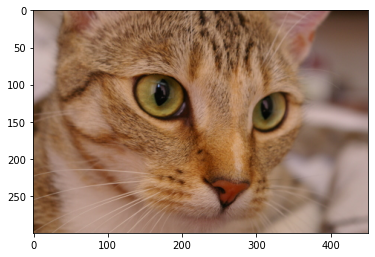


# Prediction:
Egyptian_cat : 0.74
tabby        : 0.08
tiger_cat    : 0.07
lynx         : 0.00
radiator     : 0.00


In [19]:
from skimage.data import chelsea

img = tf.keras.applications.imagenet_utils.preprocess_input(chelsea(), mode='torch') # Chelsea the cat
img = tf.image.resize(img, (224, 224))[None,] # resize & create batch
pred = model(img).numpy()
pred_dec = tf.keras.applications.imagenet_utils.decode_predictions(pred)[0]

print("\n# Image:")
plt.figure(figsize=(6,6))
plt.imshow(chelsea())
plt.show()
print()

print("# Prediction:")
for i in range(5):
    print("{:<12} : {:0.2f}".format(pred_dec[i][1], pred_dec[i][2]))

# 5. Reproducibility
* Recently, the official codebase has been updated (27 July 2022). Previously, it had some issues which resulted in a performance drop. Even after the update, the code has some [issues](https://github.com/NVlabs/GCVit/issues/11) which may result in a performance drop. Our code above already resolves those issues so no worries (those issues won't be explained here). As resolving these issues creates slight change in the architecture, official weights show different results from the paper. 
* In this section we'll try to re-evaluate the model on **ImageNetV2** dataset. 

In [20]:
import tensorflow as tf
import tensorflow_datasets as tfds

def preprocess_input(example):
    image = tf.image.resize(example['image'], (224, 224), method='bicubic')
    image = tf.keras.applications.imagenet_utils.preprocess_input(image, mode='torch')
    return image, example['label']

# Load dataset
imagenet2 = tfds.load('imagenet_v2', split='test', shuffle_files=True)
imagenet2 = imagenet2.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)
imagenet2 = imagenet2.batch(32)

# Compile Model for eval
model.compile('sgd', 'sparse_categorical_crossentropy', ['accuracy', 'sparse_top_k_categorical_accuracy'])
result = model.evaluate(imagenet2)

print("\n# Result:")
print("Acc@1: {:0.3f} | Acc@5: {:0.3f}".format(result[1], result[2]))

2022-08-19 05:58:10.520498: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling imagenet_v2-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset imagenet_v2 downloaded and prepared to /root/tensorflow_datasets/imagenet_v2/matched-frequency/3.0.0. Subsequent calls will reuse this data.


2022-08-19 05:59:15.455606: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


313/313 [==============================] - 102s 273ms/step - loss: 1.3388 - accuracy: 0.7076 - sparse_top_k_categorical_accuracy: 0.8988

# Result:
Acc@1: 0.708 | Acc@5: 0.899


# 6. Reusability
* To reuse the above codes for other tasks, I've created an open-source library ([gcvit](https://github.com/awsaf49/gcvit-tf)) with some additional features. Instead of copy-pasting the above codes, we can load the models with just a few lines of code.
* In this section, we'll be also looking into some **cool features** of this library such as `forward_features`, `forward_head`, `reset_classifier` (they are inspired by **timm** library).

In [21]:
# Install Library
!pip install -q gcvit --no-deps

# Load model with pretrained weights
from gcvit import GCViTTiny
model = GCViTTiny(pretrain=True)

# Prediction
pred = model(img)
print("prediction: ", pred.shape)

# Feature Extraction 1D
model.reset_classifier(num_classes=0, head_act=None)
feature = model(img)
print("1D feature: ",feature.shape)

# Feature Extraction 2D
feature = model.forward_features(img)
print("2D feature: ",feature.shape)

prediction:  (1, 1000)
1D feature:  (1, 512)
2D feature:  (1, 7, 7, 512)


# 7. Flower Classification
Let's train **GCViT** on Flower Classification Dataset and see how well does it do. We'll also observe **Grad-CAM** visualization to check what exactly GCViT is looking into for making decision.

## Select Device

In [22]:
try:  # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()  # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:  # detect GPUss
    tpu = None
    strategy = (
        tf.distribute.get_strategy()
    )  # default strategy that works on CPU and single GPU
print("Number of Accelerators: ", strategy.num_replicas_in_sync)

Number of Accelerators:  1


## Configuration

In [23]:
# Model
IMAGE_SIZE = [224, 224]

# TPU
if tpu:
    BATCH_SIZE = (
        16 * strategy.num_replicas_in_sync
    )  # a TPU has 8 cores so this will be 128
else:
    BATCH_SIZE = 32  # on Colab/GPU, a higher batch size may throw(OOM)

# Dataset
CLASSES = [
    "dandelion",
    "daisy",
    "tulips",
    "sunflowers",
    "roses",
]  # don't change the order

# Other constants
MEAN = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])  # imagenet mean
STD = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])  # imagenet std
AUTO = tf.data.AUTOTUNE

## Data Pipeline

In [24]:
def make_dataset(dataset: tf.data.Dataset, train: bool, image_size: int = IMAGE_SIZE):
    def preprocess(image, label):
        # for training, do augmentation
        if train:
            if tf.random.uniform(shape=[]) > 0.5:
                image = tf.image.flip_left_right(image)
        image = tf.image.resize(image, size=image_size, method="bicubic")
        image = (image - MEAN) / STD  # normalization
        return image, label

    if train:
        dataset = dataset.shuffle(BATCH_SIZE * 10)

    return dataset.map(preprocess, AUTO).batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTO)

## Flower Dataset

In [25]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers",
    split=["train[:90%]", "train[90%:]"],
    as_supervised=True,
    try_gcs=True,  # gcs_path is necessary for tpu,
)

num_train = tf.data.experimental.cardinality(train_dataset)
num_val = tf.data.experimental.cardinality(val_dataset)
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

Number of training examples: 3303
Number of validation examples: 367


## LeraningRate Scheduler

In [26]:
# Reference:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2


class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

## Prepare Dataset

In [27]:
train_dataset = make_dataset(train_dataset, True)
val_dataset = make_dataset(val_dataset, False)

## Visualize

2022-08-19 06:02:08.458757: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


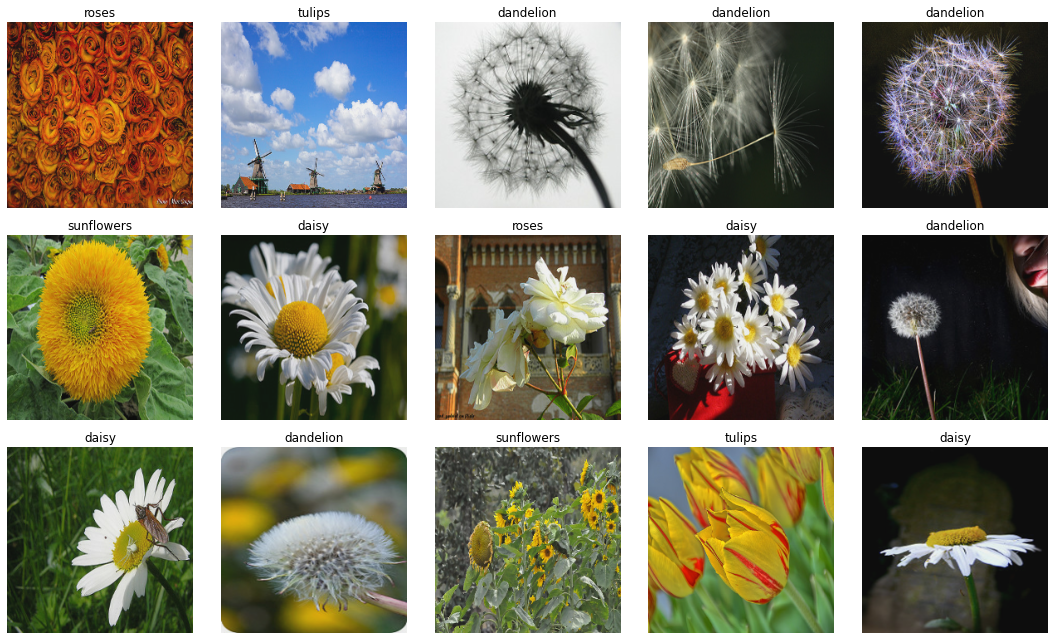

In [28]:
sample_images, sample_labels = next(iter(train_dataset))

plt.figure(figsize=(5 * 3, 3 * 3))
for n in range(15):
    ax = plt.subplot(3, 5, n + 1)
    image = (sample_images[n] * STD + MEAN).numpy()
    image = (image - image.min()) / (
        image.max() - image.min()
    )  # convert to [0, 1] for avoiding matplotlib warning
    plt.imshow(image)
    plt.title(CLASSES[sample_labels[n]])
    plt.axis("off")
plt.tight_layout()
plt.show()


## Training HyperParameters

In [29]:
EPOCHS = 10
WARMUP_STEPS = 10
INIT_LR = 0.03
WAMRUP_LR = 0.006

TOTAL_STEPS = int((num_train / BATCH_SIZE) * EPOCHS)

In [30]:
lr_schedule = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)
optimizer = tf.keras.optimizers.SGD(lr_schedule)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

## Plot LRSchedule

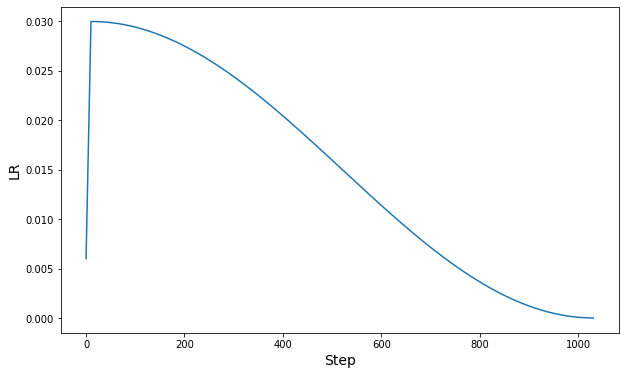

In [31]:
lrs = [lr_schedule(step) for step in range(TOTAL_STEPS)]
plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

## Building Model

In [32]:
from gcvit import GCViTTiny

with strategy.scope():    
    model = GCViTTiny(input_shape=(*IMAGE_SIZE,3), pretrain=True)
    model.reset_classifier(num_classes=104, head_act='softmax')
    
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=["accuracy"])

## Save Checkpoint

In [33]:
ckpt_path = 'model.h5'
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)

## Training

In [34]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=EPOCHS,
                    callbacks=[ckpt_callback])

Epoch 1/10
103/103 [==============================] - 114s 771ms/step - loss: 0.9942 - accuracy: 0.7212 - val_loss: 0.2582 - val_accuracy: 0.9233

Epoch 00001: val_accuracy improved from -inf to 0.92330, saving model to model.h5
Epoch 2/10
103/103 [==============================] - 72s 695ms/step - loss: 0.2382 - accuracy: 0.9208 - val_loss: 0.1614 - val_accuracy: 0.9375

Epoch 00002: val_accuracy improved from 0.92330 to 0.93750, saving model to model.h5
Epoch 3/10
103/103 [==============================] - 72s 695ms/step - loss: 0.1700 - accuracy: 0.9430 - val_loss: 0.1533 - val_accuracy: 0.9460

Epoch 00003: val_accuracy improved from 0.93750 to 0.94602, saving model to model.h5
Epoch 4/10
103/103 [==============================] - 72s 699ms/step - loss: 0.1071 - accuracy: 0.9657 - val_loss: 0.1180 - val_accuracy: 0.9545

Epoch 00004: val_accuracy improved from 0.94602 to 0.95455, saving model to model.h5
Epoch 5/10
103/103 [==============================] - 72s 695ms/step - loss: 0

## Training Plot

<AxesSubplot:xlabel='epoch', ylabel='score'>

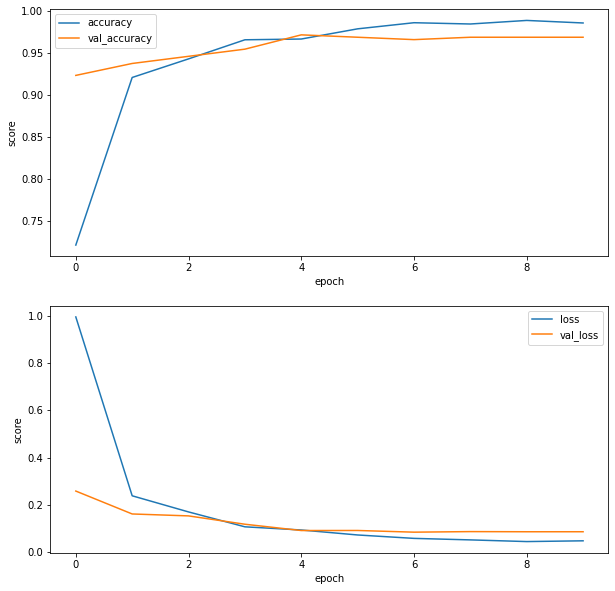

In [35]:
import pandas as pd
result = pd.DataFrame(history.history)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
result[["accuracy", "val_accuracy"]].plot(xlabel="epoch", ylabel="score", ax=ax[0])
result[["loss", "val_loss"]].plot(xlabel="epoch", ylabel="score", ax=ax[1])

## Predictions

In [36]:
sample_images, sample_labels = next(iter(val_dataset))
predictions = model.predict(sample_images, batch_size=16).argmax(axis=-1)

## Grad-CAM

In [37]:
from gcvit.utils import get_gradcam_model, get_gradcam_prediction
from tqdm import tqdm

gradcam_model = get_gradcam_model(model) # make gradcam model

# Generate Grad-CAM heatmaps
heatmaps = []
for i in tqdm(range(15)):
    pred, heatmap = get_gradcam_prediction(sample_images[i].numpy(), gradcam_model, process=False, decode=False)
    heatmaps.append(heatmap)

100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


## Visualize

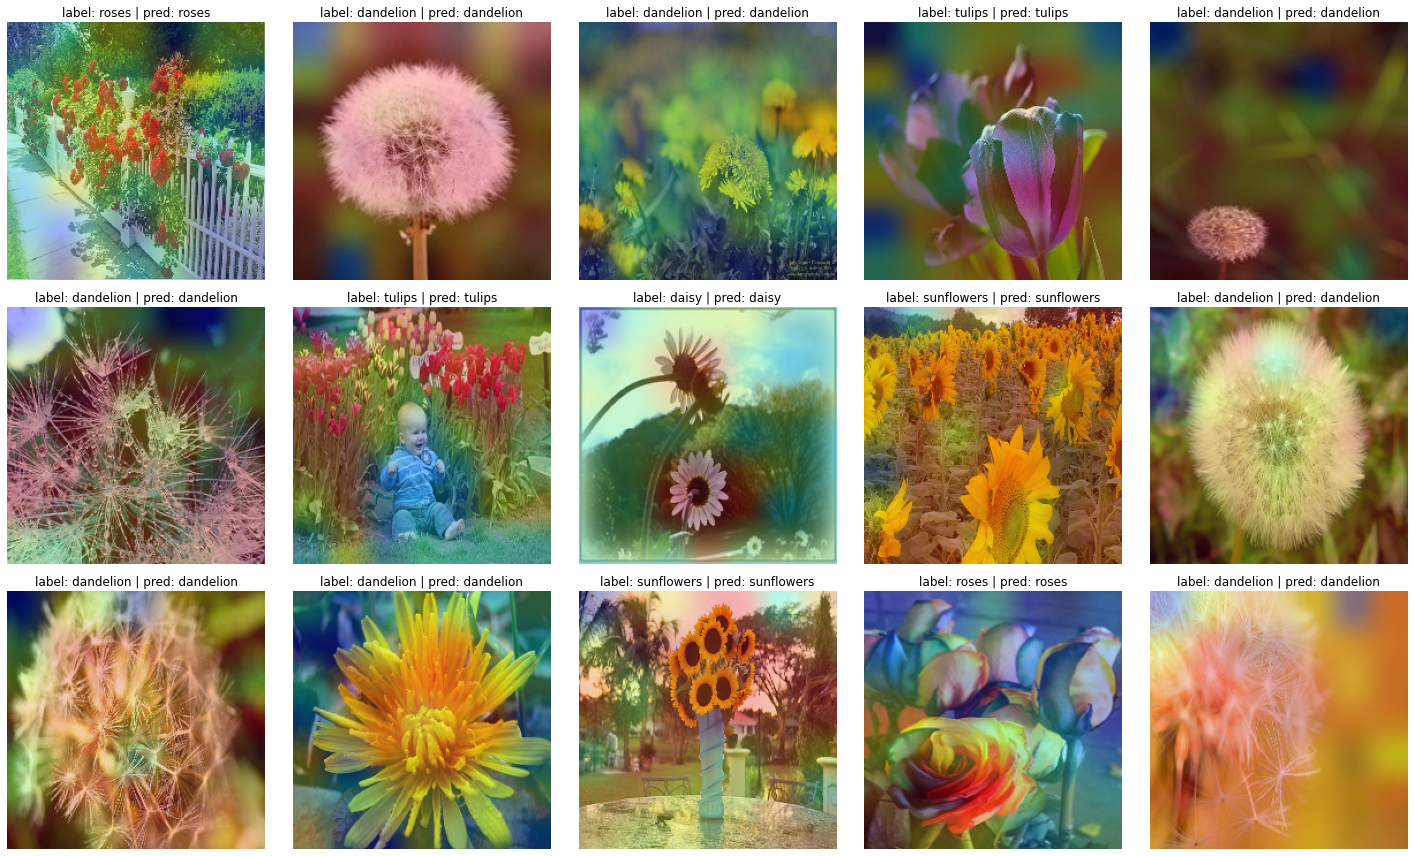

In [38]:
plt.figure(figsize=(5 * 4, 3 * 4))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(heatmaps[i])
    target = CLASSES[sample_labels[i]]
    pred = CLASSES[predictions[i]]
    plt.title("label: {} | pred: {}".format(target, pred), fontsize=12)
    plt.axis("off")
plt.tight_layout()
plt.show()

# 8. Conclusion
To conclude, this notebook explains the backstory of GCViT and the reason why it was proposed. It also implements the model in tensorflow. It also demonstrates how to re-evaluate this model on **ImageNetV2** dataset. It also shows how to use this model for other datasets and other tasks. Even though ported weights result differs from the reported result due to ongoing issues on the official codebase, we can achieve nice results by fine-tuning.

> This notebook is still under development. So, if you feel something needs to be added or I've missed anything, please let me know.

# 9. Reference

## Acknowledgement
* [GCVit](https://github.com/NVlabs/GCVit) (Official)
* [tfgcvit](https://github.com/shkarupa-alex/tfgcvit/tree/develop/tfgcvit)
* [Swin-Transformer-TF](https://github.com/rishigami/Swin-Transformer-TF)
* [keras_cv_attention_models](https://github.com/leondgarse/keras_cv_attention_model)
* [timm](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/swin_transformer.py)

## Tutorial
* [The Illustrated Transformer]() by Jay Alammar
* [Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) by Harvard NLP
* [SwinTransformer](https://amaarora.github.io/2022/07/04/swintransformerv1.html) by Aman Arora 

## Citation
```bibtex
@article{hatamizadeh2022global,
  title={Global Context Vision Transformers},
  author={Hatamizadeh, Ali and Yin, Hongxu and Kautz, Jan and Molchanov, Pavlo},
  journal={arXiv preprint arXiv:2206.09959},
  year={2022}
}
```